<a href="https://colab.research.google.com/github/Ansalnakhan/PROJECT/blob/main/autoencoder_bilstm_fcn_for_soh_and_lstm_fcn_for_rul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#mounting the drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%config Completer.use_jedi = False

In [3]:
!mkdir dataset
!cd dataset
!unzip /content/drive/MyDrive/naza.zip -d /content/dataset

Archive:  /content/drive/MyDrive/naza.zip
  inflating: /content/dataset/B0007.mat  
  inflating: /content/dataset/B0018.mat  
  inflating: /content/dataset/README.txt  
  inflating: /content/dataset/B0005.mat  
  inflating: /content/dataset/B0006.mat  


In [4]:
#importing the necessary packages
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error,r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv1D,MaxPooling1D
from tensorflow.keras.layers import Dropout,Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam


In [5]:
#DATASET

In [6]:
def load_data(battery):
  mat = loadmat('dataset/' + battery + '.mat')
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]
#TRAINING DATA(TAKEN B0005)
dataset, capacity = load_data('B0005')
pd.set_option('display.max_columns', 10)
print(dataset.head())
dataset.describe()

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  1.856487          4.191492   
1      1                   24 2008-04-02 15:25:41  1.856487          4.190749   
2      1                   24 2008-04-02 15:25:41  1.856487          3.974871   
3      1                   24 2008-04-02 15:25:41  1.856487          3.951717   
4      1                   24 2008-04-02 15:25:41  1.856487          3.934352   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.004902             24.330034       -0.0006         0.000   0.000  
1         -0.001478             24.325993       -0.0006         4.206  16.781  
2         -2.012528             24.389085       -1.9982         3.062  35.703  
3         -2.

,cycle,ambient_temperature,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
count,50285.000000,50285.0,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000
mean,88.125942,24.0,1.560345,3.515268,-1.806032,32.816991,1.362700,2.308406,1546.208924
std,45.699687,0.0,0.182380,0.231778,0.610502,3.987515,1.313698,0.800300,906.640295
min,1.000000,24.0,1.287453,2.455679,-2.029098,23.214802,-1.998400,0.000000,0.000000
25%,50.000000,24.0,1.386229,3.399384,-2.013415,30.019392,1.998000,2.388000,768.563000
50%,88.000000,24.0,1.538237,3.511664,-2.012312,32.828944,1.998200,2.533000,1537.031000
75%,127.000000,24.0,1.746871,3.660903,-2.011052,35.920887,1.998200,2.690000,2305.984000
max,168.000000,24.0,1.856487,4.222920,0.007496,41.450232,1.998400,4.238000,3690.234000


In [7]:
#The following graph shows the aging process of the battery as the charge cycles progress. The horizontal line represents the threshold related to what can be considered the end of the battery's life cycle.

Text(0.5, 1.0, 'Discharge B0005')

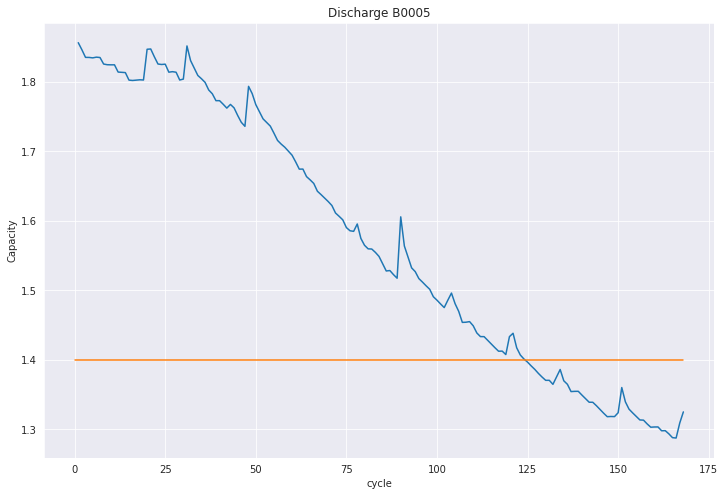

In [8]:
plot_df = capacity.loc[(capacity['cycle']>=1),['cycle','capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.plot(plot_df['cycle'], plot_df['capacity'])
#Draw threshold
plt.plot([0.,len(capacity)], [1.4, 1.4])
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

In [9]:
#this is training datayile real SOH BY EQUATION
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity'])/C
print(dis_ele.head(5))

   cycle            datetime  capacity       SoH
0      1 2008-04-02 15:25:41  1.856487  1.000000
1      2 2008-04-02 19:43:48  1.846327  0.994527
2      3 2008-04-03 00:01:06  1.835349  0.988614
3      4 2008-04-03 04:16:37  1.835263  0.988567
4      5 2008-04-03 08:33:25  1.834646  0.988235


In [10]:
#Training phase for calculating SoH

In [11]:
C = dataset['capacity'][0]
soh = []
for i in range(len(dataset)):
  soh.append([dataset['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

attribs=['capacity', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs]
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)
print(train_dataset.shape)
print(soh.shape)

(50285, 7)
(50285, 1)


In [12]:
train_dataset = np.reshape(train_dataset,(train_dataset.shape[0],train_dataset.shape[1],1))

In [13]:
#MODEL

In [14]:
from keras.models import Sequential

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, regularizers

In [16]:
from keras.layers import Dense, LSTM, Flatten,Conv1D,MaxPooling1D

In [17]:
from sklearn.metrics import mean_squared_error,confusion_matrix, accuracy_score, mean_absolute_error,r2_score
from tensorflow.keras.layers import Dropout

In [18]:
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model

In [19]:
input_shape = (train_dataset.shape[1],1)
inputs = Input(shape=input_shape)
encoded = Bidirectional(LSTM(64, return_sequences=True))(inputs)
encoded = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(encoded)
encoded = MaxPooling1D(pool_size=2)(encoded)
decoded = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(encoded)
decoded = MaxPooling1D(pool_size=2)(decoded)
decoded = Bidirectional(LSTM(64, return_sequences=True))(decoded)
decoded = Dense(7, activation='linear')(decoded)
output = Flatten()(decoded)
output = Dense(1, activation='linear')(output)
autoencoder = Model(inputs, output)
autoencoder.compile(optimizer='adam', loss='mse')

In [20]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 1)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 7, 128)           33792     
 l)                                                              
                                                                 
 conv1d (Conv1D)             (None, 7, 64)             24640     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 3, 64)             12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0     

In [21]:
autoencoder.fit(x=train_dataset, y=soh, batch_size=32, epochs=10)

Epoch 1/10
1572/1572 [==============================] - 33s 15ms/step - loss: 0.0035
Epoch 2/10
1572/1572 [==============================] - 22s 14ms/step - loss: 1.2319e-05
Epoch 3/10
1572/1572 [==============================] - 24s 15ms/step - loss: 1.4441e-05
Epoch 4/10
1572/1572 [==============================] - 24s 15ms/step - loss: 1.5830e-05
Epoch 5/10
1572/1572 [==============================] - 23s 14ms/step - loss: 1.2239e-05
Epoch 6/10
1572/1572 [==============================] - 24s 15ms/step - loss: 9.2911e-06
Epoch 7/10
1572/1572 [==============================] - 24s 15ms/step - loss: 9.0361e-06
Epoch 8/10
1572/1572 [==============================] - 24s 15ms/step - loss: 6.5748e-06
Epoch 9/10
1572/1572 [==============================] - 22s 14ms/step - loss: 6.4478e-06
Epoch 10/10
1572/1572 [==============================] - 24s 15ms/step - loss: 5.5065e-06


In [22]:
dataset_val, capacity_val = load_data('B0007')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C
print(dataset_val.head(5))
print(dis_ele.head(5))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.89105229539079, 4.199359521791473, -0.0018658918833680202, 23.93704394613529, -0.0004, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  1.891052          4.199360   
1      1                   24 2008-04-02 15:25:41  1.891052          4.199497   
2      1                   24 2008-04-02 15:25:41  1.891052          3.985606   
3      1                   24 2008-04-02 15:25:41  1.891052          3.963247   
4      1                   24 2008-04-02 15:25:41  1.891052          3.946647   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.001866             23.937044       -0.0004         0.000   0.000  
1         -0.002139             23.924074       -0.0004         4.215  16.781  
2         -1.988778             24.004257       -2.0000         3.003  35.703  
3         -1.99

In [23]:
attrib=['capacity', 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time']
soh_pred = autoencoder.predict(sc.fit_transform(dataset_val[attrib]))
print(soh_pred.shape)

C = dataset_val['capacity'][0]
soh = []
for i in range(len(dataset_val)):
  soh.append(dataset_val['capacity'][i] / C)
new_soh = dataset_val.loc[(dataset_val['cycle'] >= 1), ['cycle']]
new_soh['SoH'] =  soh
new_soh['NewSoH'] = soh_pred
new_soh = new_soh.groupby(['cycle']).mean().reset_index()
print(new_soh.head(10))
rms = np.sqrt(mean_squared_error(new_soh['SoH'], new_soh['NewSoH']))
mae = mean_absolute_error(new_soh['SoH'], new_soh['NewSoH'],multioutput='raw_values')
r2 = r2_score(new_soh['SoH'], new_soh['NewSoH'])
print('Root Mean Square Error: ', rms)
print('Mean Absolute Error: ', mae)
print('R2_score: ', r2)

1572/1572 [==============================] - 14s 8ms/step
(50285, 1)
   cycle       SoH    NewSoH
0      1  1.000000  1.001013
1      2  0.994492  0.994800
2      3  0.994506  0.994843
3      4  0.994563  0.994953
4      5  0.993865  0.994189
5      6  0.994526  0.994922
6      7  0.994121  0.994444
7      8  0.994953  0.995444
8      9  0.988704  0.988371
9     10  0.988895  0.988609
Root Mean Square Error:  0.026104350795782136
Mean Absolute Error:  [0.02161742]
R2_score:  0.905367159061117


In [25]:
soh_pred

array([[1.0006102 ],
       [0.99816316],
       [1.0020202 ],
       ...,
       [0.7134161 ],
       [0.7133507 ],
       [0.7134231 ]], dtype=float32)

Text(0.5, 1.0, 'Discharge B0007')

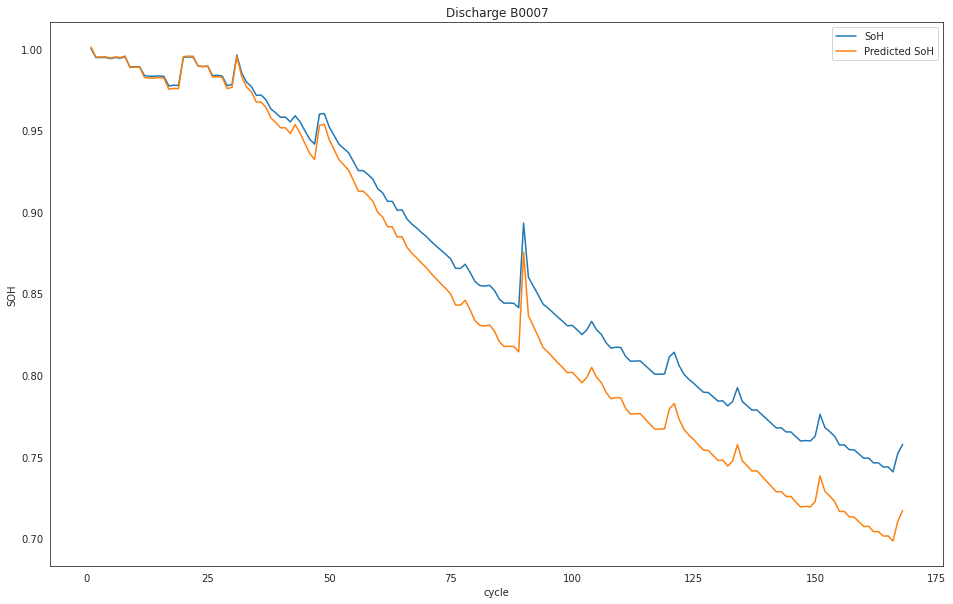

In [26]:
plot_df = new_soh.loc[(new_soh['cycle']>=1),['cycle','SoH', 'NewSoH']]
sns.set_style("white")
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['SoH'], label='SoH')
plt.plot(plot_df['cycle'], plot_df['NewSoH'], label='Predicted SoH')
#Draw threshold
#plt.plot([0.,len(capacity)], [0.70, 0.70], label='Threshold')
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0007')

In [46]:
#RUL

In [47]:
#FOR TRAINING and TESTING b0005 is used

In [48]:
dataset_val, capacity_val = load_data('B0005')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
rows=['cycle','capacity']
dataset=dis_ele[rows]
data_train=dataset[(dataset['cycle']<90)]
data_set_train=data_train.iloc[:,1:2].values
data_test=dataset[(dataset['cycle']>=90)]
data_set_test=data_test.iloc[:,1:2].values

from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler(feature_range=(0,1))
data_set_train=sc.fit_transform(data_set_train)
data_set_test=sc.transform(data_set_test)

X_train=[]
y_train=[]
#created window of 10
for i in range(10,89):
    X_train.append(data_set_train[i-10:i,0])
    y_train.append(data_set_train[i,0])
X_train,y_train=np.array(X_train),np.array(y_train)
 
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]


In [49]:
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=32))
model.add(Dropout(0.2))
model.add(Dense(64,activation='linear'))
model.add(Dense(32,activation='linear'))
model.add(Dense(8,activation='linear'))
model.add(Dense(1))


In [50]:
#optimizer
adam = tf.keras.optimizers.Adam(
    learning_rate=8e-4)
#huber loss function
model.compile(optimizer=adam,loss=tf.keras.losses.Huber(),metrics=tf.keras.metrics.RootMeanSquaredError())
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 32)            4352      
                                                                 
 dropout_2 (Dropout)         (None, 10, 32)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                2112      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 8)                

In [51]:
model.fit(X_train,y_train,epochs=150,batch_size=50)

Epoch 1/150
2/2 [==============================] - 5s 18ms/step - loss: 0.1661 - root_mean_squared_error: 0.5764
Epoch 2/150
2/2 [==============================] - 0s 13ms/step - loss: 0.0853 - root_mean_squared_error: 0.4130
Epoch 3/150
2/2 [==============================] - 0s 14ms/step - loss: 0.0310 - root_mean_squared_error: 0.2488
Epoch 4/150
2/2 [==============================] - 0s 14ms/step - loss: 0.0128 - root_mean_squared_error: 0.1598
Epoch 5/150
2/2 [==============================] - 0s 15ms/step - loss: 0.0236 - root_mean_squared_error: 0.2172
Epoch 6/150
2/2 [==============================] - 0s 19ms/step - loss: 0.0330 - root_mean_squared_error: 0.2568
Epoch 7/150
2/2 [==============================] - 0s 14ms/step - loss: 0.0246 - root_mean_squared_error: 0.2220
Epoch 8/150
2/2 [==============================] - 0s 14ms/step - loss: 0.0172 - root_mean_squared_error: 0.1855
Epoch 9/150
2/2 [==============================] - 0s 15ms/step - loss: 0.0115 - root_mean_squar

In [52]:
#### predictions
data_total=pd.concat((data_train['capacity'],data_test['capacity']),axis=0)
inputs=data_total[len(data_total)-len(data_test)-10:].values
inputs=inputs.reshape(-1,1)
inputs=sc.transform(inputs)


In [53]:
X_test=[]
for i in range(10,89):
    X_test.append(inputs[i-10:i,0])
X_test=np.array(X_test)
print(X_test.shape)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

(79, 10)


In [54]:

pred=model.predict(X_test)

3/3 [==============================] - 1s 5ms/step


In [55]:
pred

array([[-0.014219  ],
       [-0.01316347],
       [-0.00802233],
       [-0.00403652],
       [-0.00326427],
       [-0.0054485 ],
       [-0.01033015],
       [-0.01732358],
       [-0.02738617],
       [-0.03880657],
       [-0.0521324 ],
       [-0.07941244],
       [-0.09972351],
       [-0.11770422],
       [-0.13113351],
       [-0.1401316 ],
       [-0.14731228],
       [-0.15518188],
       [-0.1654595 ],
       [-0.17672963],
       [-0.1869917 ],
       [-0.19736235],
       [-0.20862266],
       [-0.22057429],
       [-0.23424007],
       [-0.24922304],
       [-0.26206186],
       [-0.27379662],
       [-0.28405958],
       [-0.29441845],
       [-0.30504167],
       [-0.31083244],
       [-0.3115038 ],
       [-0.31213033],
       [-0.31493258],
       [-0.31927872],
       [-0.3249533 ],
       [-0.3317748 ],
       [-0.33959898],
       [-0.34894994],
       [-0.35888773],
       [-0.37289235],
       [-0.38690734],
       [-0.39798504],
       [-0.40596172],
       [-0

In [56]:
pred=sc.inverse_transform(pred)

In [57]:
pred

array([[1.5126657],
       [1.5130236],
       [1.5147663],
       [1.5161176],
       [1.5163795],
       [1.515639 ],
       [1.5139841],
       [1.5116132],
       [1.5082021],
       [1.5043305],
       [1.4998131],
       [1.4905652],
       [1.4836795],
       [1.4775841],
       [1.4730316],
       [1.4699812],
       [1.4675468],
       [1.4648792],
       [1.461395 ],
       [1.4575745],
       [1.4540955],
       [1.4505799],
       [1.4467626],
       [1.442711 ],
       [1.4380782],
       [1.432999 ],
       [1.4286467],
       [1.4246684],
       [1.4211893],
       [1.4176776],
       [1.4140764],
       [1.4121134],
       [1.4118859],
       [1.4116734],
       [1.4107234],
       [1.4092501],
       [1.4073263],
       [1.4050138],
       [1.4023615],
       [1.3991914],
       [1.3958225],
       [1.391075 ],
       [1.3863238],
       [1.3825685],
       [1.3798643],
       [1.3784136],
       [1.3771603],
       [1.3758717],
       [1.3741784],
       [1.37236  ],


In [58]:


pred=pred[:,0]
tests=data_test.iloc[:,1:2]
rmse = np.sqrt(mean_squared_error(tests, pred))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(tests,pred,multioutput='raw_values')
r2 = r2_score(tests,pred)
print('Mean Absolute Error: ', mae)
print('R2_score: ', r2)
data_test['predicted']=pred
print(data_test.head())

Test RMSE: 0.024
Mean Absolute Error:  [0.01948869]
R2_score:  0.9012010147179605
    cycle  capacity  predicted
89     90  1.605819   1.512666
90     91  1.563849   1.513024
91     92  1.548092   1.514766
92     93  1.532376   1.516118
93     94  1.526953   1.516379


<ipython-input-58-323b249f48e1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['predicted']=pred


<ipython-input-59-b48cfd3de8df>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['pre']=pred


Text(0.5, 1.0, 'Discharge B0005 ')

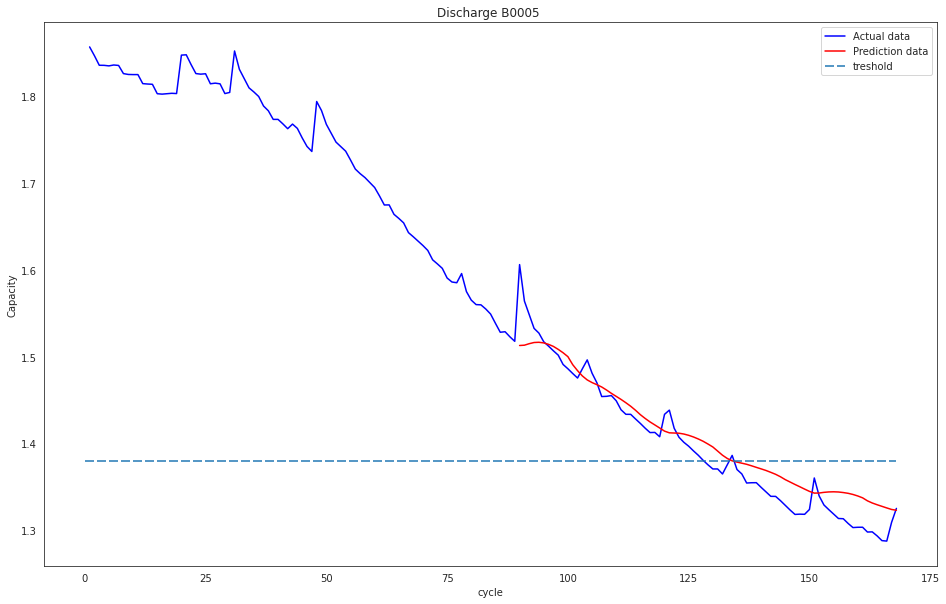

In [59]:
ln = len(data_train)
data_test['pre']=pred
plot_df = dataset.loc[(dataset['cycle']>=1),['cycle','capacity']]
plot_per = data_test.loc[(data_test['cycle']>=ln),['cycle','pre']]
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['pre'],label="Prediction data", color='red')
#Draw threshold
plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="treshold")
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0005 ')

In [60]:
pred=0
Afil=0
Pfil=0
a=data_test['capacity'].values
b=data_test['pre'].values
j=0
k=0
for i in range(len(a)):
    actual=a[i]
    
    if actual<=1.38:
        j=i
        Afil=j
        break
for i in range(len(a)):
    pred=b[i]
    if pred< 1.38:
        k=i
        Pfil=k
        break
print("The Actual fail at cycle number: "+ str(Afil+ln))
print("The prediction fail at cycle number: "+ str(Pfil+ln))
RULerror=Pfil-Afil
print("error in RUL prediction in Cycles= "+ str(RULerror)+ " Cycle(s)")

The Actual fail at cycle number: 128
The prediction fail at cycle number: 133
error in RUL prediction in Cycles= 5 Cycle(s)
